In [2]:
!pip install opacus

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 254.4/254.4 kB 11.7 MB/s eta 0:00:00


DP-EGGROLL: Experimental Validation (Aligned with LaTeX)

Configuration:
  Device: cuda
  Nominal batch size m: 256
  Target δ: 1e-05
  Target epsilons: [0.5, 1.0, 2.0, 4.0, 8.0]
  Epochs: 10
  Seeds: [42, 101, 999]
  Dataset size n: 60000
  Sample rate q = m/n: 0.004267
  Steps per epoch: 235
  Total steps T: 2350

  Hyperparameters:
    Population size N: 8192
    ES noise σ: 0.03
    Learning rate α: 0.02
    Clipping norm C: 4.0
    Sensitivity Δ_2 = C/m: 0.015625

NON-PRIVATE EGGROLL BASELINE
  Seed 42: 95.55%
  Seed 101: 95.80%
  Seed 999: 95.91%

  Non-Private EGGROLL: 95.75 ± 0.15%

TARGET EPSILON = 0.5
  Calibrated σ_DP: 1.7969
  Achieved ε: 0.4903 (target: 0.5)
  Per-coordinate noise std: 0.0281

  Running DP-EGGROLL...


/usr/local/lib/python3.12/dist-packages/opacus/accountants/analysis/rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(


    Seed 42: 87.63%
    Seed 101: 88.21%
    Seed 999: 88.47%
  DP-EGGROLL: 88.10 ± 0.35%

  Running DP-SGD...


/usr/local/lib/python3.12/dist-packages/opacus/privacy_engine.py:96: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
sys:1: UserWarning: Full backward hook is firing when gradients are computed with respect to module outputs since no inputs require gradients. See https://docs.pytorch.org/docs/main/generated/torch.nn.Module.html#torch.nn.Module.register_full_backward_hook for more details.


    Seed 42: 85.01%
    Seed 101: 86.27%
    Seed 999: 86.23%
  DP-SGD: 85.84 ± 0.58%

  Comparison for ε=0.5:
    DP-EGGROLL: 88.10% ± 0.35%
    DP-SGD:     85.84% ± 0.58%
    Gap: +2.27%

TARGET EPSILON = 1.0
  Calibrated σ_DP: 1.1621
  Achieved ε: 0.9944 (target: 1.0)
  Per-coordinate noise std: 0.0182

  Running DP-EGGROLL...
    Seed 42: 90.15%
    Seed 101: 90.40%
    Seed 999: 90.09%
  DP-EGGROLL: 90.21 ± 0.13%

  Running DP-SGD...
    Seed 42: 89.53%
    Seed 101: 90.01%
    Seed 999: 90.54%
  DP-SGD: 90.03 ± 0.41%

  Comparison for ε=1.0:
    DP-EGGROLL: 90.21% ± 0.13%
    DP-SGD:     90.03% ± 0.41%
    Gap: +0.19%

TARGET EPSILON = 2.0
  Calibrated σ_DP: 0.8557
  Achieved ε: 1.9967 (target: 2.0)
  Per-coordinate noise std: 0.0134

  Running DP-EGGROLL...
    Seed 42: 91.41%
    Seed 101: 91.29%
    Seed 999: 91.36%
  DP-EGGROLL: 91.35 ± 0.05%

  Running DP-SGD...
    Seed 42: 91.91%
    Seed 101: 92.32%
    Seed 999: 92.37%
  DP-SGD: 92.20 ± 0.21%

  Comparison for ε=2.0:
   

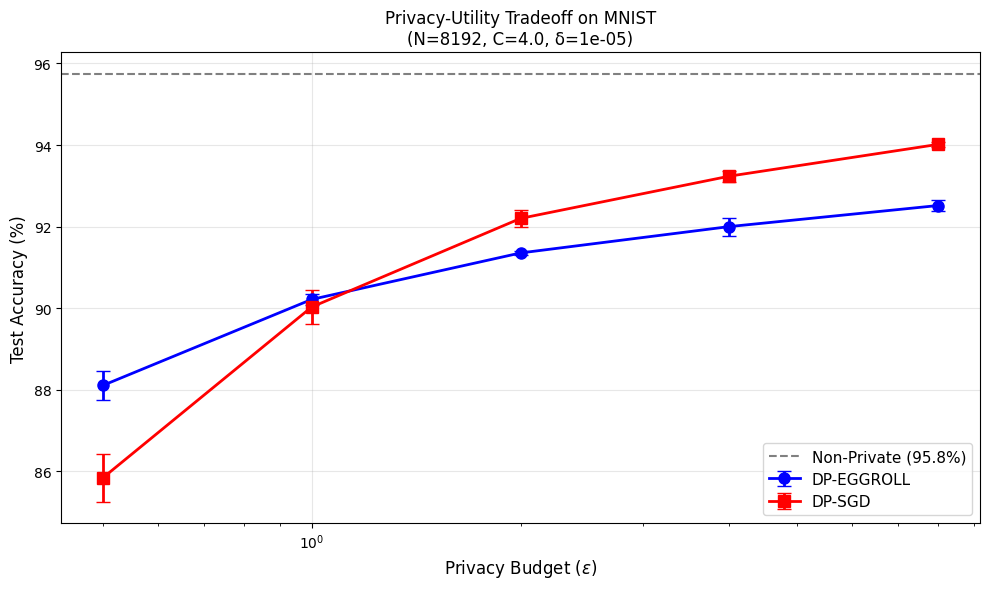

In [1]:
"""
DP-EGGROLL: Differentially Private Evolution Strategies
========================================================

This script implements the algorithm from:
"Adding Differential Privacy to Evolution Strategies via Fitness Vector Privatization"

Key implementation details:
---------------------------------
- Noise added to LOSS before negation (Algorithm 1, Lines 23-27)
- 1/σ factor included in ES gradient (Equation 4 → absorbed into α)
- Nominal batch size m in sensitivity (Lemma 1)
- Reward shaping on privatized fitness only (Section 3.6)
- Poisson subsampling for privacy amplification (Section 4.2)
- Clipping: ℓ̃_j = ℓ_j · min(1, C/‖ℓ_j‖_2) (Equation 5)
- Noise: Z ~ N(0, σ_DP² C²/m² · I_N) (Equation 7)

PRIVACY MODEL:
--------------
- Adjacency: ADD/REMOVE (datasets differ by presence/absence of one record)
  * Under replace-one adjacency, sensitivity doubles to 2C/m
  * Opacus uses add/remove adjacency with sensitivity C/m, matching our implementation
- Dataset size n is treated as a fixed public constant (use len(dataset) consistently)
  * This is the same assumption Opacus makes (see Opacus GitHub issue #571)
  * At large n this is standard practice; at very small n (e.g., 2-3 samples) it can
    leak information about dataset membership
- Sampling probability q = m/n is data-independent when n is fixed

PER-EXAMPLE DECOMPOSABILITY ASSUMPTION:
---------------------------------------
The sensitivity argument requires per-example losses to be independently
clippable. This is VIOLATED by:
- BatchNorm in training mode (batch statistics couple examples)
- Contrastive losses that pair examples
- Any objective with cross-example coupling
Use LayerNorm, GroupNorm, or BatchNorm in eval mode instead.

CRITICAL RNG REQUIREMENTS (THREE SEPARATE STREAMS):
---------------------------------------------------
1. Perturbation RNG: PUBLIC (reconstructable from step counter seed)
   - Used to generate low-rank perturbations E_i
   - Can be deterministic for reproducibility

2. DP Noise RNG: SECRET (seeded from OS entropy via secrets.randbits(64))
   - Used to generate Gaussian noise Z for privatization
   - NEVER log, transmit, or deterministically regenerate

3. Subsampling RNG: SECRET if claiming privacy amplification
   - Used for Poisson subsampling mask generation
   - PoissonSubsampledDataset uses secret_mode=True by default
   - If secret_mode=False (for reproducibility), amplification does NOT apply
     and accountant should use sample_rate=1.0

REPRODUCIBILITY VS DEPLOYMENT:
------------------------------
This script uses set_seed() for reproducibility in experiments, which affects
model initialization and shuffle order but NOT the privacy-critical RNGs:
- DP noise uses self._dp_noise_gen (secret, OS entropy)
- Subsampling uses secret_mode=True by default (secret, OS entropy)

For experiments claiming privacy amplification: seeds can be logged because
the privacy-critical RNGs are separate. For maximum security in deployment,
also enable Opacus secure_mode for DP-SGD baseline.

KEY EQUATIONS (with LaTeX line references):
-------------------------------------------
1. ES Gradient (Lines 154-157):
   ∇_μ J(μ) = (1/σ) E[E · f(μ + σE)]

2. EGGROLL Update (Lines 163-165):
   μ_{t+1} = μ_t + (α_t/(Nσ)) Σ E_{i,t} · r_i

   Note: The 1/σ from the gradient is included explicitly.

3. Clipping (Equation 5, Algorithm 1 Line 19-20):
   ℓ̃_j = ℓ_j · min(1, C/‖ℓ_j‖_2)

4. Scaled Sum with Fixed Denominator (Algorithm 1 Line 22):
   ℓ̄ = (1/m) Σ_j ℓ̃_j    [m = NOMINAL batch size, not |B_t|]

5. Noise Addition (Algorithm 1 Lines 23-24):
   Z ~ N(0, σ_DP² C²/m² · I_N)
   ℓ̂ = ℓ̄ + Z

6. Privatized Fitness (Algorithm 1 Line 27):
   f̃ = -ℓ̂ = -(ℓ̄ + Z)

   Note: Negation is post-processing; does not affect privacy.

7. Sensitivity (Lemma 1):
   Δ_2 = C/m under add/remove adjacency
   Δ_2 = 2C/m under replace-one adjacency

Author: Anonymous
License: MIT
"""

import math
import os
import random
import secrets  # For cryptographically secure DP noise seeding
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms

try:
    from opacus.accountants.utils import get_noise_multiplier
    from opacus.accountants import RDPAccountant
    from opacus import PrivacyEngine
    OPACUS_AVAILABLE = True
except ImportError:
    raise ImportError("Opacus required. Install via: pip install opacus")

# ============================================================================
# CONFIGURATION (Aligned with LaTeX Section 6.1)
# ============================================================================

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
RESULTS_DIR = "./results_aligned"
os.makedirs(RESULTS_DIR, exist_ok=True)

# Random seeds for reproducibility
SEEDS = [42, 101, 999]

# Privacy parameters (LaTeX Section 6.1)
DELTA = 1e-5
TARGET_EPSILONS = [0.5, 1.0, 2.0, 4.0, 8.0]  # Include 0.5 for key DP-EGGROLL vs DP-SGD comparison

# Training parameters
NOMINAL_BATCH_SIZE = 256  # m in the paper (LaTeX Section 6.1)
EPOCHS = 10               # Sufficient for convergence

# DP-EGGROLL parameters
RANK = 1                  # Low-rank parameter r (LaTeX Section 6.1)

# Population chunk size for memory management
POP_CHUNK_SIZE = 8192


# ============================================================================
# DATA LOADING WITH POISSON SUBSAMPLING
# ============================================================================

_DATASET_CACHE = {}

class PoissonSubsampledDataset(torch.utils.data.IterableDataset):
    """
    Implements Poisson subsampling per Algorithm 1, Lines 4-6.

    Each example is included independently with probability q = m/n.
    This is required for privacy amplification by subsampling (Section 4.2).

    CRITICAL FOR PRIVACY AMPLIFICATION:
    Privacy amplification by subsampling requires that the sampled set remains
    SECRET. This implementation uses a dedicated generator seeded from OS entropy
    by default (secret_mode=True).

    If secret_mode=False (for reproducibility), batch membership becomes
    deterministic given the global seed, and privacy amplification does NOT apply.
    In that case, the accountant should use sample_rate=1.0 (no amplification).

    DATASET SIZE CONVENTION (LaTeX Section 4.1):
    Under add/remove adjacency, the dataset size n is treated as a fixed public
    constant. This means: use len(dataset) consistently in both the mechanism
    and the accountant. This is the same assumption Opacus makes (see GitHub
    issue #571). At large n this is standard practice; at very small n it can
    leak membership information.

    LaTeX Reference (Lines 281-283):
    "Include each x ∈ D independently with probability q = m/n"
    """

    def __init__(self, dataset, sampling_probability, nominal_batch_size,
                 secret_mode=True):
        """
        Args:
            dataset: Source dataset
            sampling_probability: q = m/n
            nominal_batch_size: m (for expected batch count calculation)
            secret_mode: If True (default), use OS-entropy-seeded generator for
                        subsampling, enabling privacy amplification claims.
                        If False, use global RNG (deterministic, NO amplification).
        """
        self.sampling_probability = sampling_probability
        self.nominal_batch_size = nominal_batch_size
        self.n = len(dataset)
        self.secret_mode = secret_mode

        # Secret subsampling generator - seeded from OS entropy
        # This is CRITICAL for privacy amplification to be valid
        if secret_mode:
            self._subsampling_gen = torch.Generator()
            self._subsampling_gen.manual_seed(secrets.randbits(64))
        else:
            self._subsampling_gen = None  # Will use global RNG

        cache_key = (type(dataset).__name__, self.n)
        if cache_key not in _DATASET_CACHE:
            all_data = [dataset[i][0] for i in range(self.n)]
            all_targets = [dataset[i][1] for i in range(self.n)]
            _DATASET_CACHE[cache_key] = (
                torch.stack(all_data),
                torch.tensor(all_targets)
            )
        self.all_data, self.all_targets = _DATASET_CACHE[cache_key]

    def __iter__(self):
        num_batches = int(np.ceil(self.n / self.nominal_batch_size))
        for _ in range(num_batches):
            # Use secret generator if in secret_mode, else global RNG
            if self.secret_mode:
                mask = torch.rand(self.n, generator=self._subsampling_gen) < self.sampling_probability
            else:
                mask = torch.rand(self.n) < self.sampling_probability
            indices = torch.where(mask)[0]
            if len(indices) == 0:
                continue
            yield self.all_data[indices], self.all_targets[indices]


def get_dataloaders(batch_size, use_poisson=True, secret_subsampling=True):
    """
    Create MNIST data loaders.

    Args:
        batch_size: Nominal batch size m
        use_poisson: If True, use Poisson subsampling for DP-EGGROLL
        secret_subsampling: If True (default), subsampling uses OS-entropy-seeded
                          generator, enabling privacy amplification claims.
                          If False, uses global RNG (for reproducibility only;
                          privacy amplification does NOT apply).

    IMPORTANT: For valid privacy amplification, secret_subsampling must be True
    and the subsampling generator must never be logged or reconstructed.

    The sample_rate q = m/n uses n = len(train_dataset). This n is treated as a
    fixed public constant, the same assumption Opacus makes. At large n this is
    standard practice; at very small n it can leak membership information.
    """
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])
    train_dataset = datasets.MNIST("./data", train=True, download=True, transform=transform)
    test_dataset = datasets.MNIST("./data", train=False, transform=transform)

    train_len = len(train_dataset)
    sample_rate = batch_size / train_len

    if use_poisson:
        train_loader = torch.utils.data.DataLoader(
            PoissonSubsampledDataset(train_dataset, sample_rate, batch_size,
                                    secret_mode=secret_subsampling),
            batch_size=None,
        )
    else:
        train_loader = torch.utils.data.DataLoader(
            train_dataset, batch_size=batch_size, shuffle=True
        )

    test_loader = torch.utils.data.DataLoader(
        test_dataset, batch_size=1000, shuffle=False
    )

    return train_loader, test_loader, train_len, sample_rate


# ============================================================================
# MODEL (LaTeX Section 6.1: "784-256-10, approximately 200K parameters")
# ============================================================================

class SimpleMLP(nn.Module):
    """Two-layer MLP for MNIST (784 -> 256 -> 10, no biases)."""

    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(784, 256, bias=False)
        self.fc2 = nn.Linear(256, 10, bias=False)

    def forward(self, x):
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        return self.fc2(x)


# ============================================================================
# DP-EGGROLL OPTIMIZER
# ============================================================================

class DPEggrollOptimizer:
    """
    DP-EGGROLL optimizer implementing Algorithm 1 from the LaTeX paper.

    CRITICAL ALIGNMENT NOTES:
    -------------------------

    1. NOISE ORDER (Algorithm 1, Lines 23-27):
       The paper specifies:
         Line 24: ℓ̂ ← ℓ̄ + Z         (add noise to LOSS)
         Line 27: f̃ ← -ℓ̂            (THEN negate)

       So: f̃ = -(ℓ̄ + Z) = -ℓ̄ - Z

       This is mathematically equivalent to -ℓ̄ + Z (since Z is symmetric),
       but we follow the paper's exact order for clarity.

    2. ES GRADIENT AND UPDATE:
       LaTeX Equation (line 154-157): ∇J = (1/σ) E[E·f]
       LaTeX Update (line 163-165):   μ_{t+1} = μ_t + (α/N) Σ E_i · f_i

       The 1/σ is absorbed into α. Equivalently, we can write:
         μ_{t+1} = μ_t + (α/(Nσ)) Σ E_i · r_i

       We use the explicit 1/σ form for mathematical clarity.

    3. SENSITIVITY (Lemma 1, Lines 358-370):
       Δ_2 = C/m where m is the NOMINAL batch size.
       We divide by m even when |B_t| < m (zero-padding convention).

    4. ADJACENCY CONVENTION (LaTeX Lines 480-485):
       We use ADD/REMOVE adjacency: neighboring datasets differ by one record
       being present or absent. Under REPLACE-ONE adjacency, sensitivity doubles
       to 2C/m. Opacus uses add/remove adjacency with sensitivity C/m, matching
       our implementation exactly.

    5. RNG STREAMS (CRITICAL FOR PRIVACY):
       - Perturbation RNG: PUBLIC, seeded deterministically, can be reconstructed
       - DP Noise RNG: SECRET, seeded from OS entropy, never logged/reconstructable

       These MUST be separate streams. Using global seeded RNG for DP noise
       would make the mechanism non-private.
    """

    def __init__(self, model, pop_size, sigma_es, lr, loss_clip,
                 noise_multiplier, nominal_batch_size, rank=1,
                 dp_mode=True, device="cpu", pop_chunk_size=4000,
                 secret_noise_seed=None, use_centered_clipping=True):
        """
        Args:
            model: Neural network to optimize
            pop_size: Population size N (LaTeX: Lines 274, 592)
            sigma_es: ES perturbation scale σ (LaTeX: Line 275)
            lr: Learning rate α (LaTeX: Line 276)
            loss_clip: Clipping constant C (LaTeX: Lines 276, 596)
            noise_multiplier: DP noise multiplier σ_DP (LaTeX: Line 277, 597)
            nominal_batch_size: m for sensitivity calculation (LaTeX: Lemma 1)
            rank: Low-rank parameter r (LaTeX: Line 275)
            dp_mode: If True, apply DP mechanism
            device: Computation device
            pop_chunk_size: Max population per chunk for memory
            secret_noise_seed: If None (default), use OS entropy for DP noise.
                              If set, use deterministic seed (FOR DEBUGGING ONLY,
                              NOT A VALID DP DEPLOYMENT).
            use_centered_clipping: If True, center each per-example vector across
                              candidates before clipping. This removes the common-mode
                              component that dominates ||ℓ_j||_2, allowing smaller C
                              without heavy clipping. The centering projection is
                              non-expansive, so sensitivity bound C/m still holds.
        """
        self.model = model
        self.pop_size = pop_size
        self.sigma_es = sigma_es
        self.lr = lr
        self.loss_clip = loss_clip
        self.noise_multiplier = noise_multiplier
        self.nominal_batch_size = nominal_batch_size
        self.rank = rank
        self.dp_mode = dp_mode
        self.device = device
        self.pop_chunk_size = pop_chunk_size
        self.step_counter = 0
        self.use_centered_clipping = use_centered_clipping

        # Diagnostic counters (for debugging, do NOT expose in production)
        self._clip_fractions = []  # Track what fraction of examples are clipped

        # =================================================================
        # CRITICAL: Separate RNG streams for privacy
        # =================================================================
        # Perturbation RNG: PUBLIC (seeded deterministically per step)
        # - Created fresh each step using step_counter as seed
        # - Adversary can reconstruct perturbations (this is fine)

        # DP Noise RNG: SECRET (seeded from OS entropy)
        # - Must NEVER be logged, transmitted, or reconstructable
        # - If secret_noise_seed is set, we're in debug mode (NOT private)
        self._dp_noise_gen = torch.Generator(device=device)
        if secret_noise_seed is not None:
            print("Warning: using deterministic DP noise seed (debug mode only)")
            self._dp_noise_gen.manual_seed(secret_noise_seed)
        else:
            # Seed from OS entropy - this is the secure default
            self._dp_noise_gen.manual_seed(secrets.randbits(64))

    def get_clip_diagnostics(self):
        """
        Return clipping diagnostics from training.

        WARNING: These diagnostics are for debugging/development only.
        In a real DP deployment, exposing per-step clipping fractions
        could leak information about the data. Only use for:
        - Hyperparameter tuning on public/synthetic data
        - Understanding the clipping regime
        - Validating your choice of C

        Returns:
            dict with:
                - mean_clip_fraction: average fraction of examples clipped
                - median_clip_fraction: median fraction
                - num_steps: number of steps recorded
        """
        if not self._clip_fractions:
            return {"mean_clip_fraction": None, "median_clip_fraction": None, "num_steps": 0}

        fracs = np.array(self._clip_fractions)
        return {
            "mean_clip_fraction": float(fracs.mean()),
            "median_clip_fraction": float(np.median(fracs)),
            "num_steps": len(fracs)
        }

    def reset_diagnostics(self):
        """Clear diagnostic counters."""
        self._clip_fractions = []

    def step(self, data, target):
        """
        One DP-EGGROLL optimization step (Algorithm 1).

        Returns: mean fitness (for logging)
        """
        if self.pop_size > self.pop_chunk_size:
            return self._step_chunked(data, target)
        else:
            return self._step_vectorized(data, target)

    def _step_vectorized(self, data, target):
        """
        Vectorized implementation following Algorithm 1 exactly.

        Line-by-line correspondence with LaTeX Algorithm 1:
        - Lines 4-6: Poisson subsampling (handled by data loader)
        - Lines 8-11: Generate perturbations
        - Lines 13-15: Compute per-example loss matrix
        - Lines 17-20: Clip per-example vectors
        - Lines 22-24: Average and add noise
        - Line 27: Form privatized fitness
        - Line 28: Shape rewards
        - Line 31: EGGROLL update
        """
        actual_batch_size = data.size(0)
        step_seed = self.step_counter * 1000000
        self.step_counter += 1

        # Get base parameters
        params = list(self.model.parameters())
        W1, W2 = params[0], params[1]  # (256, 784), (10, 256)

        # =====================================================================
        # Algorithm 1, Lines 8-11: Generate perturbations (public randomness)
        # E_{i,t} = (1/√r) A_{i,t} B_{i,t}^T
        # =====================================================================
        rng = torch.Generator(device=self.device)
        rng.manual_seed(step_seed)

        scale = 1.0 / math.sqrt(self.rank)

        # Layer 1 perturbations
        A1 = torch.randn(self.pop_size, 256, self.rank, device=self.device, generator=rng)
        B1 = torch.randn(self.pop_size, 784, self.rank, device=self.device, generator=rng)
        E1 = scale * torch.bmm(A1, B1.transpose(1, 2))  # (N, 256, 784)

        # Layer 2 perturbations
        A2 = torch.randn(self.pop_size, 10, self.rank, device=self.device, generator=rng)
        B2 = torch.randn(self.pop_size, 256, self.rank, device=self.device, generator=rng)
        E2 = scale * torch.bmm(A2, B2.transpose(1, 2))  # (N, 10, 256)

        # Form perturbed weights: M_{i,t} = μ_t + σ E_{i,t} (Line 11)
        W1_all = W1.unsqueeze(0) + self.sigma_es * E1
        W2_all = W2.unsqueeze(0) + self.sigma_es * E2

        # Flatten input
        x = data.view(actual_batch_size, -1)  # (B, 784)

        # =====================================================================
        # Algorithm 1, Lines 13-15: Compute per-example loss matrix
        # L[j,i] = ℓ(M_{i,t}, x_j) for all j ∈ B_t, i ∈ [N]
        # =====================================================================
        with torch.no_grad():
            hidden = torch.einsum('bd,nod->nbo', x, W1_all)  # (N, B, 256)
            hidden = F.relu(hidden)
            logits = torch.einsum('nbd,nod->nbo', hidden, W2_all)  # (N, B, 10)

            # Per-example losses: L[j,i] = ℓ(M_i, x_j)
            log_probs = F.log_softmax(logits, dim=-1)
            target_exp = target.unsqueeze(0).expand(self.pop_size, -1)
            losses = F.nll_loss(
                log_probs.reshape(-1, 10),
                target_exp.reshape(-1),
                reduction='none'
            ).view(self.pop_size, actual_batch_size)  # (N, B)

        # =====================================================================
        # DP Mechanism (Algorithm 1, Lines 17-28)
        # =====================================================================
        if self.dp_mode:
            # -----------------------------------------------------------------
            # Lines 17-20: Clip per-example vectors
            # ℓ_j = L[j, :]  (per-example loss vector across candidates)
            #
            # OPTIONAL: Per-example centering before clipping
            # If use_centered_clipping=True, we first subtract the per-example
            # mean across candidates: u_j = ℓ_j - mean(ℓ_j)
            # This removes the common-mode component that dominates ||ℓ_j||_2.
            # The centering projection P = I - (1/N)11^T is non-expansive
            # (||Px||_2 <= ||x||_2), so clipping to C still gives sensitivity C/m.
            # -----------------------------------------------------------------
            per_example_losses = losses.t()  # (|B_t|, N) - each row is ℓ_j

            if self.use_centered_clipping:
                # Center each row: u_j = ℓ_j - mean(ℓ_j)
                row_means = per_example_losses.mean(dim=1, keepdim=True)
                vectors_to_clip = per_example_losses - row_means
            else:
                vectors_to_clip = per_example_losses

            # Compute norms and clip factors
            norms = vectors_to_clip.norm(dim=1, keepdim=True)  # ||ℓ_j||_2 or ||u_j||_2
            clip_factors = torch.clamp(self.loss_clip / (norms + 1e-8), max=1.0)

            # Track clipping diagnostics (DO NOT LOG IN PRODUCTION)
            frac_clipped = (clip_factors < 1.0).float().mean().item()
            self._clip_fractions.append(frac_clipped)

            # Apply clipping: ℓ̃_j = ℓ_j · min(1, C/||ℓ_j||_2)
            clipped_vectors = vectors_to_clip * clip_factors

            # -----------------------------------------------------------------
            # Line 22: Average with NOMINAL batch size
            # ℓ̄ = (1/m) Σ_j ℓ̃_j
            # CRITICAL: Use m (nominal), not |B_t| (actual)
            # -----------------------------------------------------------------
            avg_clipped = clipped_vectors.sum(dim=0) / self.nominal_batch_size  # (N,)

            # -----------------------------------------------------------------
            # Lines 23-24: Add Gaussian noise
            # Z ~ N(0, σ_DP² C²/m² · I_N)
            # ℓ̂ = ℓ̄ + Z
            # CRITICAL: Use SECRET RNG (self._dp_noise_gen), not global RNG
            # -----------------------------------------------------------------
            sensitivity = self.loss_clip / self.nominal_batch_size  # Δ_2 = C/m
            noise_std = self.noise_multiplier * sensitivity
            noise = torch.randn(
                self.pop_size,
                device=self.device,
                generator=self._dp_noise_gen  # SECRET RNG
            ) * noise_std
            noisy_avg = avg_clipped + noise  # ℓ̂ = ℓ̄ + Z

            # -----------------------------------------------------------------
            # Line 27: Form privatized fitness
            # f̃ = -ℓ̂
            # CRITICAL: Negate AFTER adding noise (per paper specification)
            # -----------------------------------------------------------------
            fitness = -noisy_avg  # f̃ = -ℓ̂ = -(ℓ̄ + Z)

            # -----------------------------------------------------------------
            # Line 28: Reward shaping on PRIVATIZED fitness only
            # r = shape(f̃) using only statistics of f̃
            # -----------------------------------------------------------------
            rewards = (fitness - fitness.mean()) / (fitness.std() + 1e-8)
        else:
            # Non-private: standard batch-averaged fitness
            fitness = -losses.mean(dim=1)
            rewards = (fitness - fitness.mean()) / (fitness.std() + 1e-8)

        # =====================================================================
        # Algorithm 1, Line 31: EGGROLL update
        # μ_{t+1} = μ_t + (α_t/N) Σ E_{i,t} · r_i
        #
        # NOTE ON 1/σ FACTOR:
        # The ES gradient (Equation 4) includes 1/σ: ∇J = (1/σ) E[E·f]
        # The EGGROLL update (Equation 5) absorbs this into α.
        #
        # For mathematical clarity, we use the explicit form:
        #   μ_{t+1} = μ_t + (α/(Nσ)) Σ E_i · r_i
        # =====================================================================
        with torch.no_grad():
            # Gradient for layer 1: g1 = (1/(Nσ)) Σ r_i E1_i
            grad1 = torch.einsum('n,nij->ij', rewards, E1) / (self.pop_size * self.sigma_es)
            W1.add_(grad1, alpha=self.lr)

            # Gradient for layer 2: g2 = (1/(Nσ)) Σ r_i E2_i
            grad2 = torch.einsum('n,nij->ij', rewards, E2) / (self.pop_size * self.sigma_es)
            W2.add_(grad2, alpha=self.lr)

        return fitness.mean().item()

    def _step_chunked(self, data, target):
        """Chunked implementation for large populations."""
        actual_batch_size = data.size(0)
        chunk_size = self.pop_chunk_size
        num_chunks = math.ceil(self.pop_size / chunk_size)

        step_seed = self.step_counter * 1000000
        self.step_counter += 1

        params = list(self.model.parameters())
        W1, W2 = params[0], params[1]
        x = data.view(actual_batch_size, -1)

        # Phase 1: Compute all losses
        all_losses = []
        rng = torch.Generator(device=self.device)

        for chunk_idx in range(num_chunks):
            start = chunk_idx * chunk_size
            end = min(start + chunk_size, self.pop_size)
            curr_size = end - start

            rng.manual_seed(step_seed + chunk_idx)
            scale = 1.0 / math.sqrt(self.rank)

            A1 = torch.randn(curr_size, 256, self.rank, device=self.device, generator=rng)
            B1 = torch.randn(curr_size, 784, self.rank, device=self.device, generator=rng)
            E1 = scale * torch.bmm(A1, B1.transpose(1, 2))

            A2 = torch.randn(curr_size, 10, self.rank, device=self.device, generator=rng)
            B2 = torch.randn(curr_size, 256, self.rank, device=self.device, generator=rng)
            E2 = scale * torch.bmm(A2, B2.transpose(1, 2))

            W1_chunk = W1.unsqueeze(0) + self.sigma_es * E1
            W2_chunk = W2.unsqueeze(0) + self.sigma_es * E2

            with torch.no_grad():
                hidden = torch.einsum('bd,nod->nbo', x, W1_chunk)
                hidden = F.relu(hidden)
                logits = torch.einsum('nbd,nod->nbo', hidden, W2_chunk)

                log_probs = F.log_softmax(logits, dim=-1)
                target_exp = target.unsqueeze(0).expand(curr_size, -1)
                losses = F.nll_loss(
                    log_probs.reshape(-1, 10),
                    target_exp.reshape(-1),
                    reduction='none'
                ).view(curr_size, actual_batch_size)
                all_losses.append(losses)

            del E1, E2, W1_chunk, W2_chunk, A1, B1, A2, B2

        all_losses = torch.cat(all_losses, dim=0)  # (N, B)

        # Phase 2: DP mechanism (exactly as in _step_vectorized)
        if self.dp_mode:
            per_example_losses = all_losses.t()  # (|B_t|, N)

            # Optional centering before clipping
            if self.use_centered_clipping:
                row_means = per_example_losses.mean(dim=1, keepdim=True)
                vectors_to_clip = per_example_losses - row_means
            else:
                vectors_to_clip = per_example_losses

            norms = vectors_to_clip.norm(dim=1, keepdim=True)
            clip_factors = torch.clamp(self.loss_clip / (norms + 1e-8), max=1.0)

            # Track clipping diagnostics
            frac_clipped = (clip_factors < 1.0).float().mean().item()
            self._clip_fractions.append(frac_clipped)

            clipped_vectors = vectors_to_clip * clip_factors

            # Average with NOMINAL batch size
            avg_clipped = clipped_vectors.sum(dim=0) / self.nominal_batch_size

            # Add noise to LOSS using SECRET RNG
            sensitivity = self.loss_clip / self.nominal_batch_size
            noise_std = self.noise_multiplier * sensitivity
            noise = torch.randn(
                self.pop_size,
                device=self.device,
                generator=self._dp_noise_gen  # SECRET RNG
            ) * noise_std
            noisy_avg = avg_clipped + noise

            # THEN negate to get fitness
            fitness = -noisy_avg
            rewards = (fitness - fitness.mean()) / (fitness.std() + 1e-8)
        else:
            fitness = -all_losses.mean(dim=1)
            rewards = (fitness - fitness.mean()) / (fitness.std() + 1e-8)

        del all_losses

        # Phase 3: Compute gradients
        grad1_acc = torch.zeros_like(W1)
        grad2_acc = torch.zeros_like(W2)
        rng = torch.Generator(device=self.device)

        for chunk_idx in range(num_chunks):
            start = chunk_idx * chunk_size
            end = min(start + chunk_size, self.pop_size)
            curr_size = end - start

            rng.manual_seed(step_seed + chunk_idx)
            scale = 1.0 / math.sqrt(self.rank)

            A1 = torch.randn(curr_size, 256, self.rank, device=self.device, generator=rng)
            B1 = torch.randn(curr_size, 784, self.rank, device=self.device, generator=rng)
            E1 = scale * torch.bmm(A1, B1.transpose(1, 2))

            A2 = torch.randn(curr_size, 10, self.rank, device=self.device, generator=rng)
            B2 = torch.randn(curr_size, 256, self.rank, device=self.device, generator=rng)
            E2 = scale * torch.bmm(A2, B2.transpose(1, 2))

            chunk_rewards = rewards[start:end]

            with torch.no_grad():
                grad1_acc += torch.einsum('n,nij->ij', chunk_rewards, E1)
                grad2_acc += torch.einsum('n,nij->ij', chunk_rewards, E2)

            del E1, E2, A1, B1, A2, B2

        with torch.no_grad():
            W1.add_(grad1_acc / (self.pop_size * self.sigma_es), alpha=self.lr)
            W2.add_(grad2_acc / (self.pop_size * self.sigma_es), alpha=self.lr)

        return fitness.mean().item()


# ============================================================================
# PRIVACY ACCOUNTING
# ============================================================================

def calibrate_noise_multiplier(target_epsilon, steps, sample_rate, delta=DELTA):
    """
    Calibrate σ_DP for target (ε,δ)-DP using RDP accountant.

    Per Theorem 1 (LaTeX Lines 403-415): Uses subsampled Gaussian mechanism.

    Args:
        target_epsilon: Target ε for (ε,δ)-DP
        steps: ACTUAL number of training steps (not estimated from epochs/sample_rate)
        sample_rate: Sampling probability q = m/n
        delta: Target δ
    """
    if target_epsilon == float('inf'):
        return 0.0

    try:
        noise_mult = get_noise_multiplier(
            target_epsilon=target_epsilon,
            target_delta=delta,
            sample_rate=sample_rate,
            steps=steps,
            accountant="rdp"
        )
        return noise_mult
    except Exception as e:
        print(f"  Warning: Could not calibrate for ε={target_epsilon}: {e}")
        return None


def compute_achieved_epsilon(noise_multiplier, steps, sample_rate, delta=DELTA):
    """Compute the actual (ε, δ) achieved given noise multiplier."""
    accountant = RDPAccountant()
    for _ in range(steps):
        accountant.step(noise_multiplier=noise_multiplier, sample_rate=sample_rate)

    return accountant.get_epsilon(delta=delta)


def count_steps_per_epoch(train_len, nominal_batch_size):
    """
    Count actual steps per epoch for Poisson subsampling.

    Under Poisson subsampling, we iterate ceil(n/m) times per epoch
    to match standard training dynamics.
    """
    return int(np.ceil(train_len / nominal_batch_size))


# ============================================================================
# TRAINING FUNCTIONS
# ============================================================================

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)


def evaluate(model, test_loader, device):
    """Evaluate model accuracy on test set."""
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1)
            correct += pred.eq(target).sum().item()
            total += target.size(0)
    return 100.0 * correct / total


def train_dp_eggroll(params, epochs, sample_rate, dp_mode=True, verbose=False):
    """
    Train with DP-EGGROLL.

    Args:
        params: dict with keys: pop_size, sigma_es, lr, loss_clip, noise_multiplier
        epochs: number of epochs
        sample_rate: q = m/n
        dp_mode: whether to apply DP
        verbose: print progress

    Returns:
        final test accuracy
    """
    train_loader, test_loader, _, _ = get_dataloaders(NOMINAL_BATCH_SIZE, use_poisson=True)
    model = SimpleMLP().to(DEVICE)

    optimizer = DPEggrollOptimizer(
        model=model,
        pop_size=params['pop_size'],
        sigma_es=params['sigma_es'],
        lr=params['lr'],
        loss_clip=params['loss_clip'],
        noise_multiplier=params.get('noise_multiplier', 0.0),
        nominal_batch_size=NOMINAL_BATCH_SIZE,
        rank=RANK,
        dp_mode=dp_mode,
        device=DEVICE,
        pop_chunk_size=POP_CHUNK_SIZE
    )

    for epoch in range(epochs):
        model.train()
        for data, target in train_loader:
            data, target = data.to(DEVICE), target.to(DEVICE)
            optimizer.step(data, target)

        if verbose:
            acc = evaluate(model, test_loader, DEVICE)
            print(f"    Epoch {epoch+1}/{epochs}: {acc:.2f}%")

    return evaluate(model, test_loader, DEVICE)


def train_dp_sgd(noise_multiplier, epochs, max_grad_norm=1.0):
    """
    Train with DP-SGD using Opacus.

    IMPORTANT: For fair comparison with DP-EGGROLL, we use Poisson subsampling
    via Opacus's DPDataLoader. We pass a standard DataLoader and let Opacus
    wrap it with poisson_sampling=True, which matches the subsampling model
    used in our RDP accounting.

    Adjacency convention: Opacus uses add/remove adjacency with sensitivity C/m,
    matching our DP-EGGROLL implementation exactly. Both methods use the same
    privacy accounting assumptions.
    """
    # Use standard DataLoader - Opacus will wrap it with Poisson sampling
    train_loader, test_loader, train_len, sample_rate = get_dataloaders(
        NOMINAL_BATCH_SIZE, use_poisson=False
    )
    model = SimpleMLP().to(DEVICE)
    optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
    criterion = nn.CrossEntropyLoss()

    privacy_engine = PrivacyEngine(accountant="rdp")
    model, optimizer, train_loader = privacy_engine.make_private(
        module=model,
        optimizer=optimizer,
        data_loader=train_loader,
        noise_multiplier=noise_multiplier,
        max_grad_norm=max_grad_norm,
        poisson_sampling=True,  # Opacus wraps the DataLoader with Poisson sampling
    )

    for epoch in range(epochs):
        model.train()
        for data, target in train_loader:
            data, target = data.to(DEVICE), target.to(DEVICE)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

    return evaluate(model, test_loader, DEVICE)


# ============================================================================
# MAIN EXPERIMENT
# ============================================================================

def main():
    print("=" * 70)
    print("DP-EGGROLL: Experimental Validation (Aligned with LaTeX)")
    print("=" * 70)
    print(f"\nConfiguration:")
    print(f"  Device: {DEVICE}")
    print(f"  Nominal batch size m: {NOMINAL_BATCH_SIZE}")
    print(f"  Target δ: {DELTA}")
    print(f"  Target epsilons: {TARGET_EPSILONS}")
    print(f"  Epochs: {EPOCHS}")
    print(f"  Seeds: {SEEDS}")

    # Get sample rate and compute ACTUAL step counts
    _, _, train_len, sample_rate = get_dataloaders(NOMINAL_BATCH_SIZE, use_poisson=False)
    steps_per_epoch = count_steps_per_epoch(train_len, NOMINAL_BATCH_SIZE)
    total_steps = EPOCHS * steps_per_epoch
    print(f"  Dataset size n: {train_len}")
    print(f"  Sample rate q = m/n: {sample_rate:.6f}")
    print(f"  Steps per epoch: {steps_per_epoch}")
    print(f"  Total steps T: {total_steps}")

    results = []

    # =========================================================================
    # Hyperparameters (tuned for DP setting per Section 5.5)
    # =========================================================================
    # Key insight from Section 5.1: DP noise variance = O(σ_DP² C²/(m² N σ²))
    # Larger N helps average out DP noise

    BASE_PARAMS = {
        'pop_size': 8192,      # Moderate N (paper recommends ≲10³ but larger helps)
        'sigma_es': 0.03,      # ES perturbation scale σ
        'lr': 0.02,            # Learning rate α (absorbs 1/σ scaling)
        'loss_clip': 4.0,      # Clipping norm C
    }

    print(f"\n  Hyperparameters:")
    print(f"    Population size N: {BASE_PARAMS['pop_size']}")
    print(f"    ES noise σ: {BASE_PARAMS['sigma_es']}")
    print(f"    Learning rate α: {BASE_PARAMS['lr']}")
    print(f"    Clipping norm C: {BASE_PARAMS['loss_clip']}")

    sensitivity = BASE_PARAMS['loss_clip'] / NOMINAL_BATCH_SIZE
    print(f"    Sensitivity Δ_2 = C/m: {sensitivity:.6f}")

    # =========================================================================
    # Non-Private Baseline
    # =========================================================================
    print("\n" + "=" * 70)
    print("NON-PRIVATE EGGROLL BASELINE")
    print("=" * 70)

    np_accs = []
    for seed in SEEDS:
        set_seed(seed)
        acc = train_dp_eggroll(BASE_PARAMS, EPOCHS, sample_rate, dp_mode=False)
        np_accs.append(acc)
        print(f"  Seed {seed}: {acc:.2f}%")

    np_mean, np_std = np.mean(np_accs), np.std(np_accs)
    print(f"\n  Non-Private EGGROLL: {np_mean:.2f} ± {np_std:.2f}%")

    results.append({
        'epsilon': float('inf'),
        'method': 'EGGROLL (non-private)',
        'mean_acc': np_mean,
        'std_acc': np_std,
        'noise_multiplier': 0.0
    })

    # =========================================================================
    # DP-EGGROLL and DP-SGD for each epsilon
    # =========================================================================
    for eps in TARGET_EPSILONS:
        print("\n" + "=" * 70)
        print(f"TARGET EPSILON = {eps}")
        print("=" * 70)

        # Calibrate noise using ACTUAL step count
        noise_mult = calibrate_noise_multiplier(eps, total_steps, sample_rate)
        if noise_mult is None:
            print(f"  Skipping ε={eps} (calibration failed)")
            continue

        # Verify achieved epsilon using ACTUAL step count
        achieved_eps = compute_achieved_epsilon(noise_mult, total_steps, sample_rate)
        print(f"  Calibrated σ_DP: {noise_mult:.4f}")
        print(f"  Achieved ε: {achieved_eps:.4f} (target: {eps})")

        # Per-coordinate noise analysis
        noise_per_coord = noise_mult * sensitivity
        print(f"  Per-coordinate noise std: {noise_per_coord:.4f}")

        # DP-EGGROLL
        print(f"\n  Running DP-EGGROLL...")
        params = BASE_PARAMS.copy()
        params['noise_multiplier'] = noise_mult

        egg_accs = []
        for seed in SEEDS:
            set_seed(seed)
            acc = train_dp_eggroll(params, EPOCHS, sample_rate, dp_mode=True)
            egg_accs.append(acc)
            print(f"    Seed {seed}: {acc:.2f}%")

        egg_mean, egg_std = np.mean(egg_accs), np.std(egg_accs)
        print(f"  DP-EGGROLL: {egg_mean:.2f} ± {egg_std:.2f}%")

        results.append({
            'epsilon': eps,
            'method': 'DP-EGGROLL',
            'mean_acc': egg_mean,
            'std_acc': egg_std,
            'noise_multiplier': noise_mult
        })

        # DP-SGD baseline
        print(f"\n  Running DP-SGD...")
        sgd_accs = []
        for seed in SEEDS:
            set_seed(seed)
            acc = train_dp_sgd(noise_mult, EPOCHS)
            sgd_accs.append(acc)
            print(f"    Seed {seed}: {acc:.2f}%")

        sgd_mean, sgd_std = np.mean(sgd_accs), np.std(sgd_accs)
        print(f"  DP-SGD: {sgd_mean:.2f} ± {sgd_std:.2f}%")

        results.append({
            'epsilon': eps,
            'method': 'DP-SGD',
            'mean_acc': sgd_mean,
            'std_acc': sgd_std,
            'noise_multiplier': noise_mult
        })

        # Comparison
        print(f"\n  Comparison for ε={eps}:")
        print(f"    DP-EGGROLL: {egg_mean:.2f}% ± {egg_std:.2f}%")
        print(f"    DP-SGD:     {sgd_mean:.2f}% ± {sgd_std:.2f}%")
        gap = egg_mean - sgd_mean
        print(f"    Gap: {gap:+.2f}%")

    # =========================================================================
    # Save Results
    # =========================================================================
    df = pd.DataFrame(results)
    df.to_csv(os.path.join(RESULTS_DIR, "results.csv"), index=False)

    # =========================================================================
    # Generate LaTeX Table for Paper Section 6
    # =========================================================================
    print("\n" + "=" * 70)
    print("LATEX TABLE FOR PAPER (Section 6)")
    print("=" * 70)

    # Get non-private result
    np_row = df[df['method'] == 'EGGROLL (non-private)'].iloc[0]

    print("""
\\begin{table}[h]
\\centering
\\caption{MNIST test accuracy (\\%) comparison. Privacy: $(\\varepsilon, 10^{-5})$-DP.
Hyperparameters: $N=""" + str(BASE_PARAMS['pop_size']) + "$, $C=" + str(BASE_PARAMS['loss_clip']) + """$,
$m=""" + str(NOMINAL_BATCH_SIZE) + """$.}
\\label{tab:results}
\\begin{tabular}{lcc}
\\toprule
\\textbf{Method} & \\textbf{Test Accuracy} & \\textbf{Privacy} \\\\
\\midrule""")

    print(f"Non-private EGGROLL & {np_row['mean_acc']:.1f} $\\pm$ {np_row['std_acc']:.1f}\\% & None \\\\")
    print("\\midrule")

    for eps in TARGET_EPSILONS:
        egg_rows = df[(df['epsilon'] == eps) & (df['method'] == 'DP-EGGROLL')]
        sgd_rows = df[(df['epsilon'] == eps) & (df['method'] == 'DP-SGD')]

        if len(egg_rows) == 0:
            continue

        egg_row = egg_rows.iloc[0]
        sgd_row = sgd_rows.iloc[0]

        # Bold the winner
        if egg_row['mean_acc'] > sgd_row['mean_acc']:
            egg_str = f"\\textbf{{{egg_row['mean_acc']:.1f}}} $\\pm$ {egg_row['std_acc']:.1f}\\%"
            sgd_str = f"{sgd_row['mean_acc']:.1f} $\\pm$ {sgd_row['std_acc']:.1f}\\%"
        else:
            egg_str = f"{egg_row['mean_acc']:.1f} $\\pm$ {egg_row['std_acc']:.1f}\\%"
            sgd_str = f"\\textbf{{{sgd_row['mean_acc']:.1f}}} $\\pm$ {sgd_row['std_acc']:.1f}\\%"

        print(f"DP-EGGROLL & {egg_str} & $\\varepsilon={eps}$ \\\\")
        print(f"DP-SGD & {sgd_str} & $\\varepsilon={eps}$ \\\\")
        if eps != TARGET_EPSILONS[-1]:
            print("\\midrule")

    print("""\\bottomrule
\\end{tabular}
\\end{table}""")

    # =========================================================================
    # Generate Plot
    # =========================================================================
    plt.figure(figsize=(10, 6))

    plt.axhline(y=np_row['mean_acc'], color='gray', linestyle='--',
                label=f'Non-Private ({np_row["mean_acc"]:.1f}%)')

    egg_data = df[df['method'] == 'DP-EGGROLL']
    if len(egg_data) > 0:
        plt.errorbar(egg_data['epsilon'], egg_data['mean_acc'],
                    yerr=egg_data['std_acc'], marker='o', capsize=5,
                    label='DP-EGGROLL', color='blue', linewidth=2, markersize=8)

    sgd_data = df[df['method'] == 'DP-SGD']
    if len(sgd_data) > 0:
        plt.errorbar(sgd_data['epsilon'], sgd_data['mean_acc'],
                    yerr=sgd_data['std_acc'], marker='s', capsize=5,
                    label='DP-SGD', color='red', linewidth=2, markersize=8)

    plt.xscale('log')
    plt.xlabel(r'Privacy Budget ($\varepsilon$)', fontsize=12)
    plt.ylabel('Test Accuracy (%)', fontsize=12)
    plt.title(f'Privacy-Utility Tradeoff on MNIST\n' +
              f'(N={BASE_PARAMS["pop_size"]}, C={BASE_PARAMS["loss_clip"]}, δ={DELTA})')
    plt.legend(fontsize=11)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(os.path.join(RESULTS_DIR, "privacy_utility.png"), dpi=300)
    plt.savefig(os.path.join(RESULTS_DIR, "privacy_utility.pdf"))
    print(f"\nPlot saved to {RESULTS_DIR}/")

    print("=" * 70)
    print("EXPERIMENT COMPLETE")
    print("=" * 70)


if __name__ == "__main__":
    main()